在阅读 https://kexue.fm/archives/8728 之后，觉得CAN的原理不好理解。

阅读原文后也没完全理解其中的思想。

主要可以概括如下：
  假设试卷中A,B,C,D是等概率的。

  一张试卷仅仅4道题目，前3道有把握答案为A,B,C,最后一道没有把握的题目是否为D?

  从A,B,C,D等概率可以推算出，试卷中A,B,C,D的等概率出现的机率较大。

  这是因为试卷中出现A,B,C,D包含了4! 总共24种情况，其余比如说，两个A,其他为B,C,D中的两个，则仅仅包含了4！/2! 12种情况。
  


不过是不是能通过简单的后处理来提升网络性能呢？

这里试验了3种情况。分别是：仅仅将预测概率乘以一个值，对概率进行线性变换（乘以一个矩阵），或者进行完全的线性变换（乘以几个矩阵再加上偏置）
用神经网络的方法来训练系数。这些系数被初始化为全等变换。
实验结果显示，上面的方法几乎没有区别。

他们效果上等同于一个更简单的变换方法。就是把系数设置为类别的实际数目/网络预测数目。


这方法于CAN背后的思想不同。
这不是个全局的方法，这就像一个人考试时，发现自己每次选择A时，正确答案为B的概率都会增加一些，所以对每道题目的答案都做一个调整。


后续改进:分类器的输出，理论上为迪利克雷分布。能不能对模型再校正一次，来得到更好的效果呢?


  
 




In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os 
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import tensorflow_hub as hub


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

对Resnet的结果进行一次线性变换。初始化为单位矩阵。


In [3]:

class Mylinear(layers.Layer):

  def __init__(self, units=1001,**kwargs):
      super(Mylinear, self).__init__(**kwargs)
      self.w= tf.Variable(
          np.ones(units),
          dtype=tf.float32,
         trainable=True 
      )

  def build(self, input_shape):  # Create the state of the layer (weights)
      pass
  
  def call(self, inputs):  # Defines the computation from inputs to outputs
      return inputs*self.w

In [4]:
   
def make_model(t):
    #使用均方根误差而不是交叉熵，
    #可能因为均方根误差产生的结果更加平均
    myloss1=tf.keras.losses.MeanSquaredError()
    #myloss1=tf.keras.losses.CategoricalCrossentropy()
    
    if t=='dense':
        model=keras.Sequential(
            layers.Dense(1001,name='dense1',use_bias=False,kernel_initializer=tf.keras.initializers.Identity())
        )
    elif t=='dense_with_bias':
        model=keras.Sequential(
            layers.Dense(1001,name='dense1',use_bias=True,kernel_initializer=tf.keras.initializers.Identity())
        )

    elif t=='linear':
          model=keras.Sequential(
            Mylinear(1001,name='dense1')
        )
    else:
        raise Exception("unsupported type")

    model.compile(optimizer='RMSprop',
                    loss=myloss1,
                    metrics=['accuracy'])
    return model

In [5]:
def ds_generator(pred,bg):
    def g1():
        f1=open(pred,'rb')
        f2=open(bg,'rb')
        while True:
            try:
                y_hat=pickle.load(f1)
                y=pickle.load(f2)
                for i,a in enumerate(y_hat):
                    #print(a)
                    #print(i)
                    yield tf.convert_to_tensor(a),tf.convert_to_tensor(y[i])
            except:
                break

    return g1

def make_ds(pred,bg):
        ds=tf.data.Dataset.from_generator(ds_generator(pred,bg),output_signature=(
                tf.TensorSpec(shape=(1001,), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int64),
                )
        ).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
        ds_batch=ds.map( lambda x,y: (tf.nn.softmax(x),tf.one_hot(y,depth=1001))).batch(1024)
        return (ds,ds_batch)

In [6]:


ds_train,ds_train_batch=make_ds('imgnet_train_pred.p','imgnet_train_bg.p')
ds_val,ds_val_batch=make_ds('imgnet_val_pred.p','imgnet_val_bg.p')



使用三种神经网络比较性能
1)矩阵
2)乘法
3)全线性变换

In [7]:
model_full=make_model('dense')
model_lin=make_model('linear')
model_full_with_bias=make_model('dense_with_bias')


In [8]:
hist_base=model_full.evaluate(ds_val_batch)

49/49 [==============================] - 37s 746ms/step - loss: 4.7580e-04 - accuracy: 0.6747


In [9]:
model_lin.fit(ds_train_batch,validation_data=ds_val_batch
    ,epochs=1)

1252/1252 [==============================] - 926s 740ms/step - loss: 3.6965e-04 - accuracy: 0.7406 - val_loss: 4.5667e-04 - val_accuracy: 0.6761


In [10]:
model_full.fit(ds_train_batch,validation_data=ds_val_batch
    ,epochs=1)

1252/1252 [==============================] - 12s 9ms/step - loss: 3.6885e-04 - accuracy: 0.7409 - val_loss: 4.5538e-04 - val_accuracy: 0.6764


In [11]:

model_full_with_bias.fit(ds_train_batch,validation_data=ds_val_batch
    ,epochs=1)

1252/1252 [==============================] - 11s 9ms/step - loss: 3.6924e-04 - accuracy: 0.7409 - val_loss: 4.5624e-04 - val_accuracy: 0.6764


上面使用了神经网络的方法来校正模型的输出。

下边使用个更简单的方法。

统计验证集上每个类别的预测的个数，真实类别的个数。

使用二者的比值作为校正系数。


In [12]:
y_p=np.zeros(1001)
y_p_pred=np.zeros(1001)
for y_hat,y in ds_train.as_numpy_iterator():
    
    y_p[y]=y_p[y]+1
    p=np.argmax(y_hat)
    y_p_pred[p]=y_p_pred[p]+1



/home/hj/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


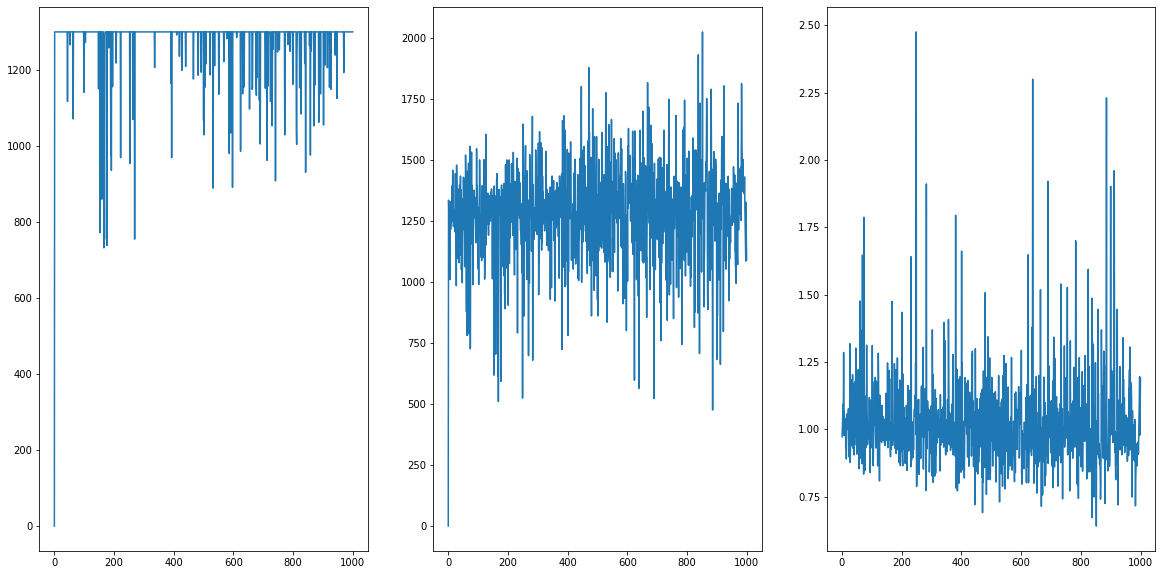

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(y_p)
plt.subplot(1,3,2)
plt.plot(y_p_pred)
plt.subplot(1,3,3)
plt.plot(y_p/y_p_pred)

In [24]:
model_lin_simple=make_model('linear')
model_lin_simple.evaluate(ds_val_batch)
model_lin_simple.evaluate(ds_train_batch)

1252/1252 [==============================] - 14s 10ms/step - loss: 3.7869e-04 - accuracy: 0.7400


[0.0003786897286772728, 0.7399831414222717]

In [29]:
layer=model_lin_simple.get_layer('dense1')

In [20]:
a=y_p/y_p_pred
a[0]=1

/home/hj/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [101]:
layer.set_weights([np.clip(a,0.5,2)])

In [31]:
model_lin_simple.evaluate(ds_train_batch)

1252/1252 [==============================] - 14s 10ms/step - loss: 3.8365e-04 - accuracy: 0.7416


[0.00038365263026207685, 0.7415879368782043]

In [102]:
model_lin_simple.evaluate(ds_val_batch)

49/49 [==============================] - 1s 12ms/step - loss: 4.7898e-04 - accuracy: 0.6765


[0.00047897850163280964, 0.6764600276947021]

统计模型的结果

In [103]:

model=model_lin_simple
c_orig_true=0
c_new_true=0
c_orig_true_new_false=0
c_orig_false_new_true=0
orig_true_new_false =[]
orig_false_new_true =[]
for sample in ds_val_batch.as_numpy_iterator():
    y_hat,y=sample
    y_hat_hat = model.predict(y_hat)
    orig_true=tf.argmax(y_hat,axis=1)==tf.argmax(y,axis=1)
    new_true = tf.argmax(y_hat_hat,axis=1)==tf.argmax(y,axis=1)
    c_orig_true=c_orig_true+np.sum(orig_true)
    c_new_true=c_new_true+np.sum(new_true)
    orig_true_new_false_index=np.logical_and(orig_true,np.logical_not(new_true))
    orig_false_new_true_index=np.logical_and(new_true,np.logical_not(orig_true))
    c_orig_true_new_false = c_orig_true_new_false + np.sum(orig_true_new_false_index)
    c_orig_false_new_true = c_orig_false_new_true + np.sum(orig_false_new_true_index)
    orig_true_new_false.append((y_hat[orig_true_new_false_index],y[orig_true_new_false_index]))
    orig_false_new_true.append((y_hat[orig_false_new_true_index],y[orig_false_new_true_index]))
    

In [104]:
c_orig_true,c_new_true,c_orig_true_new_false,c_orig_false_new_true

(33734, 33823, 231, 320)

In [61]:
c_new_true/c_orig_true-1

0.0025790004150114676